At the end of AFTCore convergence we have some estimated R and T values and I will name them initially for my algorithm as:

R0 and T0

We also have a deformed model M (3xN)

Using the camera calibration matrix we can project those values in the image as a perpective projection:

P = (u, v, w) = K \* (R0 \* M + T) (in homogeneous coordinates)

p = (u / w, v/ w) (in image plane)

For example the following is a perspective projection with R being the identity matrix (no rotation) and T = (200, 0 0) vs an orthographic projection. 

![media\ortho_vs_persp.PNG](media\ortho_vs_persp.PNG)

Thus we can optimize the function  K \* (R \* M + T) by minimizing the reprojection error

min || p - m ||   

where m are the measured feature points

the variables that will be optimized will be R and T

![media\GT_VS_EST.PNG](media\GT_VS_EST.PNG)

Improvements to add:

Normalize values, 

Optimize with constraints (r y p between ranges)

Set weights to the Jacobian matrix (r y p  values tend to go wild, so if I set a lower weight for their derivatives in J then the convergence might be better)


[[728.455   0.    320.   ]
 [  0.    728.455 240.   ]
 [  0.      0.      1.   ]]
0.439285714286


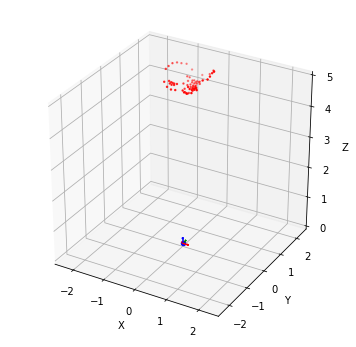

Y must increase downwards, X must increase to the right, and Z must increase in front


In [98]:
import numpy as np
import math
from math import sin, cos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import cv2
points_3d_s = """static const PCA_POINT Frontal_MIDDLE_PCA_POINT[] = {
         {2791, {-37.3342526528987970f,  19.3098761097109350f, -10.4752325848268340f}, Frontal_MIDDLE_evectors + 0},
         {3273, {-24.4794828978287850f,  20.2775648954617860f,  -5.8791049052353825f}, Frontal_MIDDLE_evectors + 48},
         {3308, {-13.4600909955903420f,  16.3121268581479870f,  -5.2476315165555896f}, Frontal_MIDDLE_evectors + 96},
         {5264, {-50.0558352227918420f,  12.5271765039087470f, -19.8763965278613310f}, Frontal_MIDDLE_evectors + 144},
         {962, { 38.3324525053435110f,  19.3435940895305090f, -10.7407217678907130f}, Frontal_MIDDLE_evectors + 192},
         {4746, { 50.4076801205811550f,  12.4513948426682290f, -19.8861466660668780f}, Frontal_MIDDLE_evectors + 240},
         {1491, { 24.1590320508100800f,  20.2853678739868640f,  -5.6764737013554658f}, Frontal_MIDDLE_evectors + 288},
         {1531, { 13.9241694211281040f,  16.3599172099044740f,  -5.1002248860752992f}, Frontal_MIDDLE_evectors + 336},
         {2801, {-37.8235211425150840f,   3.6689433161900942f, -13.8595418402314490f}, Frontal_MIDDLE_evectors + 384},
         {4479, {-37.5380532104213320f,  -3.0461826831433085f, -14.8963691896727500f}, Frontal_MIDDLE_evectors + 432},
         {4581, {-42.2210388985809930f,   0.0128545045058240f, -18.9869829531774880f}, Frontal_MIDDLE_evectors + 480},
         {5281, {-24.2380522717587680f,   4.0638920899999977f, -12.7299559775031130f}, Frontal_MIDDLE_evectors + 528},
         {520, {-18.0044616183515130f,  -0.5481063716188593f, -15.4090640264039250f}, Frontal_MIDDLE_evectors + 576},
         {5274, {-31.5372596467801640f,   4.9977426462502628f, -12.0029829984280280f}, Frontal_MIDDLE_evectors + 624},
         {2871, {-33.4802792610190070f,  -3.8850317617155854f, -13.4068988193720710f}, Frontal_MIDDLE_evectors + 672},
         {2872, {-28.3597599734058220f,  -3.7980899147265186f, -12.5572036772198730f}, Frontal_MIDDLE_evectors + 720},
         {4352, { 37.4706670502093360f,  -3.0873197070813845f, -14.7750734305528690f}, Frontal_MIDDLE_evectors + 768},
         {4755, { 24.0593777878587680f,   3.8592854832423935f, -12.7128536862792530f}, Frontal_MIDDLE_evectors + 816},
         {980, { 31.5133607360672130f,   5.0328320522136218f, -12.0579846423131210f}, Frontal_MIDDLE_evectors + 864},
         {325, { 42.0015122293680250f,  -0.0114936460065205f, -18.6696837547236820f}, Frontal_MIDDLE_evectors + 912},
         {1047, { 28.2895914629342680f,  -3.7726463488911359f, -12.4991896762823980f}, Frontal_MIDDLE_evectors + 960},
         {4409, { 16.4469807712440850f,  -0.9873075965807667f, -14.7802926745332530f}, Frontal_MIDDLE_evectors + 1008},
         {1050, { 33.3203824649582570f,  -3.8515818786542559f, -13.3289419975304280f}, Frontal_MIDDLE_evectors + 1056},
         {973, { 37.6934405580394340f,   3.5668204437422628f, -13.6967143746465720f}, Frontal_MIDDLE_evectors + 1104},
         {4879, {  0.1246392185593285f, -33.6920904187828190f,  22.7049575528243180f}, Frontal_MIDDLE_evectors + 1152},
         {1423, {  0.0609023796152987f, -27.4676526194097690f,  22.1416450522491460f}, Frontal_MIDDLE_evectors + 1200},
         {1852, {  0.0456294479171456f, -19.5666573516241050f,  16.7279572583527880f}, Frontal_MIDDLE_evectors + 1248},
         {4669, {  0.1592268397488683f, -11.6145080109054760f,  10.0695388461442420f}, Frontal_MIDDLE_evectors + 1296},
         {1431, {  0.0000000000000000f,   0.0000000000000000f,   0.0000000000000000f}, Frontal_MIDDLE_evectors + 1344},
         {4705, {  0.0610122262886125f, -43.6121730340553740f,   8.2011158414518022f}, Frontal_MIDDLE_evectors + 1392},
         {3652, {-12.2811503489955760f, -32.1288863079343660f,  12.1059367408522580f}, Frontal_MIDDLE_evectors + 1440},
         {1877, { 12.4318272919628840f, -32.2080556450690660f,  12.3480308410042030f}, Frontal_MIDDLE_evectors + 1488},
         {660, {-18.2889460598942150f, -36.1078611701421580f,  -0.9178397061819258f}, Frontal_MIDDLE_evectors + 1536},
         {4458, {  8.9250598921085889f, -41.3151186629659360f,   3.9358865856717871f}, Frontal_MIDDLE_evectors + 1584},
         {4597, { -8.7469595293311322f, -41.2518735785736580f,   3.8460748867009871f}, Frontal_MIDDLE_evectors + 1632},
         {309, { 18.6134801477990310f, -36.2358466400586180f,  -0.9868062215078208f}, Frontal_MIDDLE_evectors + 1680},
         {1120, { 24.6348271782113210f, -67.4212745953375930f,  -7.9680868546046320f}, Frontal_MIDDLE_evectors + 1728},
         {1155, {  8.3297666091020286f, -56.8468289675364890f,   8.6341725513753982f}, Frontal_MIDDLE_evectors + 1776},
         {2988, { -8.2289423458954101f, -77.8103630171331990f,   5.1057544644951243f}, Frontal_MIDDLE_evectors + 1824},
         {1453, {  0.0893852900326039f, -57.4364514555955670f,  10.0025878786374510f}, Frontal_MIDDLE_evectors + 1872},
         {2479, { 18.4769989998408380f, -61.0319430968977270f,   1.9854109214792524f}, Frontal_MIDDLE_evectors + 1920},
         {50, { 20.2538728074212810f, -72.8156400374656130f,  -3.7750025704487493f}, Frontal_MIDDLE_evectors + 1968},
         {2966, { -8.1278283286874817f, -56.8199742145104590f,   8.6080103398325321f}, Frontal_MIDDLE_evectors + 2016},
         {397, {-19.9296990446996140f, -72.8259067312952770f,  -3.6887416658623304f}, Frontal_MIDDLE_evectors + 2064},
         {5627, {-24.4135466082649160f, -67.4871893909839290f,  -7.9438651463163330f}, Frontal_MIDDLE_evectors + 2112},
         {4252, {-18.2178925342611110f, -61.1067743627980490f,   1.9077466406489432f}, Frontal_MIDDLE_evectors + 2160},
         {1182, {  8.9158710111369004f, -77.8158407805017020f,   4.9991862060868044f}, Frontal_MIDDLE_evectors + 2208},
         {1183, {  0.2351487646765861f, -78.8558268897249090f,   6.3849990426803300f}, Frontal_MIDDLE_evectors + 2256},
         {1443, {  0.1048071481066910f, -63.5635759306287370f,   6.2242219034545778f}, Frontal_MIDDLE_evectors + 2304},
         {4309, { -6.9606869432673646f, -63.6538513452271740f,   4.9586536732668023f}, Frontal_MIDDLE_evectors + 2352},
         {1158, {  0.1090101634932168f, -71.3576506689489920f,   5.6696647676352701f}, Frontal_MIDDLE_evectors + 2400},
         {2972, {-10.0565274591895460f, -70.7715812997616210f,   2.8067477785947705f}, Frontal_MIDDLE_evectors + 2448},
         {2539, {  7.2802695166978149f, -63.6598493367764820f,   4.8998559092180454f}, Frontal_MIDDLE_evectors + 2496},
         {1164, { 10.3476733708584930f, -70.7382589253223700f,   2.8076231912677803f}, Frontal_MIDDLE_evectors + 2544},
         {2632, {-64.7154885814981070f, -20.9211098738174500f, -41.5703791405910860f}, Frontal_MIDDLE_evectors + 2592},
         {3472, {-51.0546217688570610f, -81.9121157828764550f, -36.1320787684436130f}, Frontal_MIDDLE_evectors + 2640},
         {5468, {-64.1342268002929220f, -34.9670226886817020f, -44.2861326056392600f}, Frontal_MIDDLE_evectors + 2688},
         {3534, {-57.4017820805601320f, -68.9312535091625450f, -42.5283439871303910f}, Frontal_MIDDLE_evectors + 2736},
         {3542, {-61.6510621103668650f, -51.4930260654056300f, -46.6871464976462320f}, Frontal_MIDDLE_evectors + 2784},
         {3670, {-41.9506105759163290f, -94.3387792750050240f, -31.1279065422870320f}, Frontal_MIDDLE_evectors + 2832},
         {3815, {-27.6766130304002050f, -99.6365746172843100f, -14.4038975259356000f}, Frontal_MIDDLE_evectors + 2880},
         {1712, {  0.2020053296667762f, -107.3757505938070600f,  -0.8803400017974115f}, Frontal_MIDDLE_evectors + 2928},
         {2035, { 27.7918419155659850f, -99.5924639333685210f, -14.0383669990958850f}, Frontal_MIDDLE_evectors + 2976},
         {1894, { 42.1540282457970150f, -94.3823034709506600f, -31.0275847091825310f}, Frontal_MIDDLE_evectors + 3024},
         {4968, { 64.4130326748080790f, -34.9049134890828580f, -44.2215987560490480f}, Frontal_MIDDLE_evectors + 3072},
         {1762, { 57.5512155204926050f, -69.0115759497346200f, -42.4471064687297140f}, Frontal_MIDDLE_evectors + 3120},
         {795, { 64.9522070341439390f, -20.9023911910231170f, -41.5035350666180490f}, Frontal_MIDDLE_evectors + 3168},
         {1691, { 51.1244115577963070f, -82.0734226894065700f, -35.9366928803423780f}, Frontal_MIDDLE_evectors + 3216},
         {1766, { 61.8779235052766620f, -51.4871293154014540f, -46.6521637816157830f}, Frontal_MIDDLE_evectors + 3264},
};         /**< Set of 3D points defining the deformable 3D model.*/
"""

random_noise = np.random.randn(2,69) * 2

DO_NOT_CONSIDER_OX_OY = False
PIXEL_WIDTH_IS_PIXEL_HEIGHT = True
USE_ESTIMATED_CAMERA_MATRIX = False

def load_points(points_3d_s, apply_revert = True, apply_translation = True):
    # load the 3d values
    points_3d_s = s.split("\n")
    points_float = []
    for line in points_3d_s[1:-2]:
        string_values = line.split(", {")[1].split("}, ")[0].replace("f"," ").split(",")
        string_values = [float(x) for x in string_values]
        points_float.append(string_values)
    points_3d = np.array(points_float).T
    
    #scale is in milimeters, I should normalize it in decimeters
    points_3d /=100

    if apply_revert:
        points_3d[2,:] *=-1
        points_3d[1,:] *=-1
        if apply_translation == True:
            points_3d[2,:] +=500/ 100 #500 milimeters to 5 decimeters
    return points_3d

def createCalibMatrix(fx, fy,ox,oy):#f_pixel_x, f_pixel_y
    if PIXEL_WIDTH_IS_PIXEL_HEIGHT == True:
        return np.array([[  fx ,   0.  ,  ox], #increasing this will move the face to the right of the image
                         [  0. ,   fx  ,  oy], #increasing this will move the face to the bottom of the image
                         [  0. ,   0.  ,       1.    ]])
    elif USE_ESTIMATED_CAMERA_MATRIX == True:
        #fx and fy is 728.455  and 546.341
        return np.array([[712.42102051,   0.        , 318.72370623],
                         [  0.        , 719.76025391,  224.35704794],
                         [  0.        ,   0.        ,  1.        ]])
    else:
        return np.array([[  fx ,   0.  ,  ox], #increasing this will move the face to the right of the image
                         [  0. ,   fy  ,  oy], #increasing this will move the face to the bottom of the image
                         [  0. ,   0.  ,       1.    ]])

def createCameraMatrix_1(f_pixel_x, f_pixel_y,ox,oy):
    K = createCalibMatrix(f_pixel_x, f_pixel_y,ox,oy)
    R = np.eye(3)
    C = np.zeros(3)
    t = -C
    return K.dot(np.insert(R , 3, -R.dot(t), axis=1)), R, C

def createCameraMatrix_2(deg, f_pixel_x, f_pixel_y,ox,oy):
    K = createCalibMatrix(f_pixel_x, f_pixel_y,ox,oy)
    R = RotX(0).dot(RotY(0)).dot(RotZ(0))
    C = np.array([30, 0,0])
    t = -C
    R__ = RotX(0).dot(RotY(-deg)).dot(RotZ(0))
    return K.dot(np.insert(R__, 3, R__.dot(t), axis=1)), R, C

def RotY(deg):
    return np.array([[cos(deg),  0, sin(deg)],
                     [    0   ,  1,   0    ],
                     [-sin(deg), 0, cos(deg)]])
def RotZ(deg):
    return np.array([[cos(deg), -sin(deg),  0],
                     [sin(deg), cos(deg) ,  0],
                     [0       , 0        ,  1]])
def RotX(deg):
    return np.array([[1,    0    ,     0    ],
                     [0, cos(deg), -sin(deg)],
                     [0, sin(deg),  cos(deg)]])
    


def plotFacesModel(face_model, R1, C1, R2, C2, f, fig, subplot_code, fov_x, fov_y):
    ax = fig.add_subplot(subplot_code,projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-250 / 100.0,250 / 100.0)
    ax.set_ylim(-250/ 100.0,250/ 100.0)
    ax.set_zlim(0,500/ 100.0)

    #camera1
    heading_vector = np.array([[0,0,f]]).T
    heading_vector = R1.dot(heading_vector)
    
    #oposite_len_x means the W/2 of the base of the pyramid
    #oposite_len_y means the H/2 of the base of the pyramid
    print  math.tan(math.radians(fov_x / 2) )  
    oposite_len_x = f * math.tan(math.radians(fov_x / 2) )  
    oposite_len_y = f * math.tan(math.radians(fov_y / 2) )
    ox = oposite_len_x
    oy = oposite_len_y
    
    ax.quiver(0,0,0,heading_vector[0],heading_vector[1],heading_vector[2])
    ax.scatter(C1[0],C1[1],C1[2],c="b")
    v = np.array([[C1[0]     , C1[1]     ,C1[2]],   #  v0 center
                  [C1[0] + ox, C1[1] - oy, f     ],   #  v1 right --------up
                  [C1[0] + ox, C1[1] + oy, f     ],   #  v2 right----------down
                  [C1[0] - ox, C1[1] + oy, f     ],   #  v3 left---------down
                  [C1[0] - ox, C1[1] - oy, f     ]])  #  v4 left--------up
    #           right face             bottom face        left face            upper face
    verts = [[v[0], v[1], v[2]], [v[0], v[2], v[3]], [v[0], v[3], v[4]], [v[0], v[4], v[1]]]
    #https://stackoverflow.com/questions/39408794/python-3d-pyramid
    trans = 0.2
    colour = (0.1,0.8,0.5,trans)
    ax.add_collection3d(Poly3DCollection(verts, facecolors=colour, linewidths=1, edgecolors='r', alpha=.15))
    xs = face_model[0,:]
    ys = face_model[1,:]
    zs = face_model[2,:]
    ax.scatter(xs,ys,zs, s=2.0,  c='r')
    
    
    #camera2
    heading_vector = np.array([[0,0,f]]).T
    heading_vector = R2.dot(heading_vector)
    ax.quiver(C2[0],C2[1],C2[2],heading_vector[0],heading_vector[1],heading_vector[2])
    ax.scatter(C2[0],C2[1],C2[2],c="b")
    v = np.array([[C2[0]     , C2[1]     ,C2[2]],   #  v0 center
                  [C2[0] + ox, C2[1] - oy, f     ],   #  v1 right --------up
                  [C2[0] + ox, C2[1] + oy, f     ],   #  v2 right----------down
                  [C2[0] - ox, C2[1] + oy, f     ],   #  v3 left---------down
                  [C2[0] - ox, C2[1] - oy, f     ]])  #  v4 left--------up
    v = R2.dot(v.T).T
    #           right face             bottom face        left face            upper face
    verts = [[v[0], v[1], v[2]], [v[0], v[2], v[3]], [v[0], v[3], v[4]], [v[0], v[4], v[1]]]
    trans = 0.2
    colour = (0.1,0.8,0.5,trans)
    ax.add_collection3d(Poly3DCollection(verts, facecolors=colour, linewidths=1, edgecolors='r', alpha=.15))


    #x y z axes
    ax.quiver(0,0,0,20/ 100.0,0,0, colors='r')
    ax.quiver(0,0,0,0,20/ 100.0,0, colors='g')
    ax.quiver(0,0,0,0,0,20/ 100.0, colors='b')
    
def plotProjections(P1, P2, model_3d, ox, oy, fig, subplot_code):
    #camera 1
    ox = abs(ox)
    oy = abs(oy)
    image1 = np.ones((int(oy) * 2,int(ox) * 2,3), np.uint8) * 255
    homogeneous_model_3d = np.vstack((model_3d, np.ones(model_3d.shape[1])))
    projected_points1 = P1.dot(homogeneous_model_3d)
    projected_points1 /= projected_points1[2,:]
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32)
        y = projected_points1[1,i].astype(np.int32)
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
        
    #camera 2
    image2 = np.ones((int(oy) * 2,int(ox) * 2,3), np.uint8) * 255
    homogeneous_model_3d = np.vstack((model_3d, np.ones(model_3d.shape[1])))
    projected_points2 = P2.dot(homogeneous_model_3d)
    projected_points2 /= projected_points2[2,:]
    
    for i in range(projected_points2.shape[1]):
        x = projected_points2[0,i].astype(np.int32)
        y = projected_points2[1,i].astype(np.int32)
        image2 = cv2.circle(image2,(x,y), 4, (0,0,255), -1)
    ax = fig.add_subplot(subplot_code)
    subplot_code +=1
    
    ax.imshow(image1)
    ax = fig.add_subplot(subplot_code)
    subplot_code +=1
    ax.imshow(image2)

def getCameraParams():
    img_w = 640
    img_h = 480
    f_mm = 4200.0 / 100000 # 4200 is in um, thus -> dm # initially was to mm by dividing by 1000
    pixel_width = 3690.0 / 100000
    #http://answers.opencv.org/question/17076/conversion-focal-distance-from-mm-to-pixels/
    f_pixel_x = (f_mm / pixel_width) * img_w
    f_pixel_y = (f_mm / pixel_width) * img_h
    if DO_NOT_CONSIDER_OX_OY:
        ox = 0
        oy = 0
    else:
        ox = img_w /2
        oy = img_h /2
    #https://stackoverflow.com/questions/39992968/how-to-calculate-field-of-view-of-the-camera-from-camera-intrinsic-matrix?rq=1
    fov_x = 2* math.atan(img_w/(2*f_pixel_x)) * 180.0 / math.pi
    fov_y = 2* math.atan(img_h/(2*f_pixel_y)) * 180.0 / math.pi
    return img_w, img_h, f_pixel_x, f_pixel_y, ox, oy, fov_x, fov_y, f_mm
    

img_w, img_h, f_pixel_x, f_pixel_y, ox, oy, fov_x, fov_y, f_mm = getCameraParams()
K = createCalibMatrix(f_pixel_x, f_pixel_y,ox,oy)
print K
face_model = load_points(points_3d_s, apply_revert = True, apply_translation = True)
P1, R1, C1  = createCameraMatrix_1(f_pixel_x, f_pixel_y, ox,oy)
P2, R2, C2  = createCameraMatrix_2(-0.2, f_pixel_x, f_pixel_y, ox,oy)

plt.rcParams['figure.figsize'] = [6, 6]
fig = plt.figure()
plotFacesModel(face_model, R1, C1, R2, C2, f_mm, fig, subplot_code = 111, fov_x = fov_x, fov_y = fov_y) 
plt.show()

print "Y must increase downwards, X must increase to the right, and Z must increase in front"

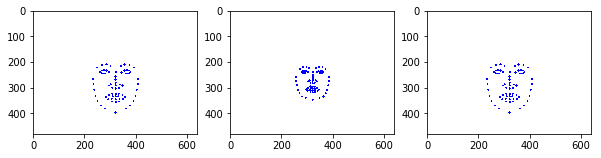

In [99]:
def plotPerspective(P1, model_3d, img_w, img_h, fig, subplot_code):

    #camera 1  first model
    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    homogeneous_model_3d = np.vstack((model_3d, np.ones(model_3d.shape[1])))
    projected_points1 = P1.dot(homogeneous_model_3d)
    projected_points1 /= projected_points1[2,:]
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32)
        y = projected_points1[1,i].astype(np.int32)
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)
    
def plotOrthographic(R1, C1, model_3d, img_w, img_h, fig, subplot_code):

    #camera 1  first model
    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    projected_points1 = R1.dot(model_3d * 100) + C1.reshape((3,1))
    
    if DO_NOT_CONSIDER_OX_OY:
        ox = 0
        oy = 0
    else:
        ox = img_w / 2
        oy = img_h / 2
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32) + ox
        y = projected_points1[1,i].astype(np.int32) + oy
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)
    
def plotPerspective_v2(R1, C1, model_3d, img_w, img_h, fig, subplot_code):
    K = createCalibMatrix(f_pixel_x, f_pixel_y, ox, oy)
    #camera 1  first model
    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    projected_points1 = K.dot(R1.dot(model_3d) + C1.reshape((3,1)))
    projected_points1 /= projected_points1[2,:]
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32)
        y = projected_points1[1,i].astype(np.int32)
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
plotPerspective(P1, face_model, img_w, img_h, fig, subplot_code = 131)
plotOrthographic(R1, C1, face_model, img_w, img_h, fig, subplot_code = 132)
plotPerspective_v2(R1, C1, face_model, img_w, img_h, fig, subplot_code = 133)
plt.show()


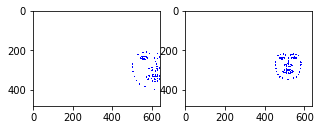

In [100]:
face_model_copy = face_model.copy()
face_model_copy[0,:] +=200/ 100.0

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
plotPerspective(P1, face_model_copy, img_w, img_h, fig, subplot_code = 121)
plotOrthographic(R1, C1, face_model_copy, img_w, img_h, fig, subplot_code = 122)
plt.show()

1.1251871352639022


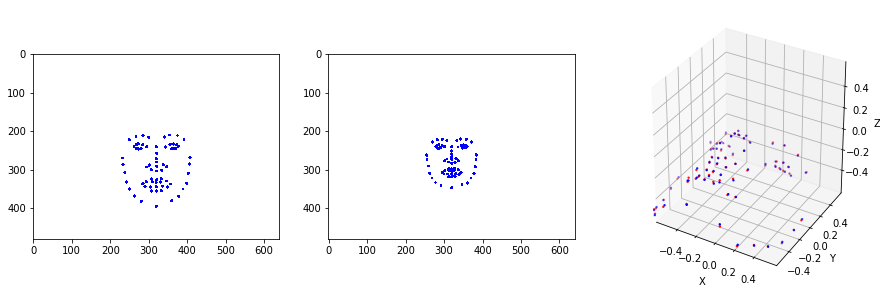

In [101]:

def load_evectors(n_points, n_eigenvectors):
    evectors = np.zeros((n_points * 3, n_eigenvectors))
    evectors = []
    with open("Frontal_MIDDLE_evectors.txt", "r") as f:
        lines = f.readlines()
        for line in lines[1:-1]:
            line = line.replace("{","").replace("}","").replace(",","").replace("f","").replace("F","").split()
            values = [float(x) for x in line]
            evectors = evectors +values
    evectors = np.array(evectors)
    evectors = evectors.reshape(n_points * 3, n_eigenvectors)
    return evectors


def load_pDeformation():
    pDeformation = []
    with open("pDeformation.txt", "r") as f:
        lines = f.readlines()
        for line in lines:
            pDeformation.append(float(line))
    pDeformation = np.array(pDeformation)
    return pDeformation

def plotDeformedVSOriginal(fig, deformed, original, subplot_code):
    ax = fig.add_subplot(subplot_code,projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-60/ 100.0,60/ 100.0)
    ax.set_ylim(-60/ 100.0,60/ 100.0)
    ax.set_zlim(-60/ 100.0,60/ 100.0)

    xs = deformed[0,:]
    ys = deformed[1,:]
    zs = deformed[2,:]
    ax.scatter(xs,ys,zs, s=2.0,  c='r')
    xs = original[0,:]
    ys = original[1,:]
    zs = original[2,:]
    ax.scatter(xs,ys,zs, s=2.0,  c='b')


evectors = load_evectors(face_model.shape[1], 48)
pDeformation = load_pDeformation()

original_model = load_points(points_3d_s, apply_revert = False)
delta_model = evectors.dot(pDeformation).reshape(-1, 1)/ 100.0

face_model_copy = original_model.copy().reshape((original_model.shape[0] * original_model.shape[1], 1))
original_model = original_model.reshape((original_model.shape[0] * original_model.shape[1], 1))
face_model_copy = original_model + delta_model
original_model = original_model.reshape(face_model.shape)
face_model_copy = face_model_copy.reshape(original_model.shape)


plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
print np.sum(np.abs(face_model_copy - original_model))
plotDeformedVSOriginal(fig, face_model_copy, original_model, subplot_code = 133)

original_model_2 = original_model.copy()
original_model_2[2,:] *=-1
original_model_2[1,:] *=-1
original_model_2[2,:] +=500/ 100.0
face_model_copy_2 = face_model_copy.copy()
face_model_copy_2[2,:] *=-1
face_model_copy_2[1,:] *=-1
face_model_copy_2[2,:] +=500/ 100.0
plotPerspective(P1, face_model_copy_2, img_w, img_h, fig, subplot_code = 131)
plotOrthographic(R1, C1, face_model_copy_2, img_w, img_h, fig, subplot_code = 132)


plt.show()


In [102]:
K = createCalibMatrix(f_pixel_x, f_pixel_y, ox, oy)

In [103]:
def plotOrthographic_V3(model_3d, img_w, img_h, fig, subplot_code):

    #camera 1  first model
    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    projected_points1 = model_3d * 100
    
    if DO_NOT_CONSIDER_OX_OY:
        ox = 0
        oy = 0
    else:
        ox = img_w / 2
        oy = img_h / 2
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32) + ox
        y = projected_points1[1,i].astype(np.int32) + oy
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)
    
def plotPerspective_V3( model_3d, img_w, img_h, fig, subplot_code):
    K = createCalibMatrix(f_pixel_x, f_pixel_y, ox, oy)
    #camera 1  first model
    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    projected_points1 = K.dot(model_3d)
    projected_points1 /= projected_points1[2,:]
    
    for i in range(projected_points1.shape[1]):
        x = projected_points1[0,i].astype(np.int32)
        y = projected_points1[1,i].astype(np.int32)
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)
    
def plotComputedProjection( Proj, img_w, img_h, fig, subplot_code):

    image1 = np.ones((img_h, img_w ,3), np.uint8) * 255
    
    for i in range(Proj.shape[1]):
        x = Proj[0,i].astype(np.int32)
        y = Proj[1,i].astype(np.int32)
        image1 = cv2.circle(image1,(x,y), 4, (0,0,255), -1)
    
    ax = fig.add_subplot(subplot_code)
    ax.imshow(image1)

In [104]:
def f_no_persp(RPY,T,C):
    """
        RPY is rotation angles 3x1
        T is translation matrix 3x1
        K is calibration matrix 3x3 (has focal length)
        C is the constant value (the average model) displaced 500 mm from the camera
    """
    roll = RPY[0,0]
    pitch = RPY[1,0]
    yaw = RPY[2,0]
    #R = RotZ(roll).dot(RotX(pitch).dot(RotY(yaw)))
    R = RotY(yaw).dot(RotX(pitch).dot(RotZ(roll)))
    Proj = R.dot(C) + T.reshape((3,1))
    return Proj

In [126]:
def f(RPY,T,K,C):
    """
        RPY is rotation angles 3x1
        T is translation matrix 3x1
        K is calibration matrix 3x3 (has focal length)
        C is the constant value (the average model) displaced 500 mm from the camera
    """
    roll = RPY[0,0]
    pitch = RPY[1,0]
    yaw = RPY[2,0]
    
    #R = RotZ(roll).dot(RotX(pitch).dot(RotY(yaw)))
    R = RotY(yaw).dot(RotX(pitch).dot(RotZ(roll)))
    Proj = K.dot(R.dot(C) + T.reshape((3,1)))
    Proj /= Proj[2,:]
    return Proj[:2,:] 

def get_du_dR(fx, p, ox):#p is feature point not projected
    du_dR = np.zeros((1,9), dtype=np.float32)
    du_dR[0,:3] = (fx * (p))#[:,0] #put the [:,0] in order to avoid broadcasting errors
    du_dR[0,6:9] = (ox * (p))#[:,0]
    return du_dR

def get_dv_dR(fy, p, oy):#p is feature point not projected
    dv_dR = np.zeros((1,9), dtype=np.float32)
    dv_dR[0,3:6] = (fy * (p))#[:,0] #put the [:,0] in order to avoid broadcasting errors
    dv_dR[0,6:9] = (oy * (p))#[:,0]
    return dv_dR

def get_dw_dR(p):#p is feature point not projected
    dw_dR = np.zeros((1,9), dtype=np.float32)
    dw_dR[0,6:9] = (p)#[:,0] #put the [:,0] in order to avoid broadcasting errors
    return dw_dR
def get_df_dR(K,p,p_proj):
    #slide useful at https://www.coursera.org/learn/robotics-perception/lecture/oDj0o/bundle-adjustment-i
    #minute 13:54
    df_dR = np.zeros((2,9), dtype=np.float32)
    du_dR = get_du_dR(K[0,0], p, K[0,2]) 
    dv_dR = get_dv_dR(K[1,1], p, K[1,2])
    dw_dR = get_dw_dR(p)
    u = p_proj[0]
    v = p_proj[1]
    w = p_proj[2]
    df_dR[0,:] = (w*du_dR - u*dw_dR) / (w**2)
    df_dR[1,:] = (w*dv_dR - v*dw_dR) / (w**2)
    return df_dR

def get_dR_dThX(R):#thetaX
    P = np.array([[0 ,0 ,0 ],
                  [0, 0, -1],
                  [0, 1, 0]], dtype=np.float32)
    dR_dThX = R.dot(P)
    dR_dThX = dR_dThX.reshape((-1,1))
    return dR_dThX

def get_dR_dThY(R):#thetaY
    P = np.array([[0, 0,  1],
                  [0, 0,  0],
                  [-1, 0, 0]], dtype=np.float32)
    dR_dThY = R.dot(P)
    dR_dThY = dR_dThY.reshape((-1, 1))
    return dR_dThY
    
def get_dR_dThZ(R):#thetaZ
    P = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 0]], dtype=np.float32)
    dR_dThZ = R.dot(P)
    dR_dThZ = dR_dThZ.reshape((-1, 1))
    return dR_dThZ

def get_dR_dThZXY(R):
    dR_dThX = get_dR_dThX(R)
    dR_dThY = get_dR_dThY(R)
    dR_dThZ = get_dR_dThZ(R)
    #dR_dThXZY = np.hstack((dR_dThX, dR_dThY, dR_dThZ))# so the order of rotation is X then Z then Y
    dR_dThZXY = np.hstack((dR_dThZ, dR_dThX, dR_dThY ))# so the order of rotation is Z then X then Y
    return dR_dThZXY

def RotY(deg):
    return np.array([[cos(deg),  0, sin(deg)],
                     [    0   ,  1,   0    ],
                     [-sin(deg), 0, cos(deg)]])
def RotZ(deg):
    return np.array([[cos(deg), -sin(deg),  0],
                     [sin(deg), cos(deg) ,  0],
                     [0       , 0        ,  1]])
def RotX(deg):
    return np.array([[1,    0    ,     0    ],
                     [0, cos(deg), -sin(deg)],
                     [0, sin(deg),  cos(deg)]])

def get_df_dT(K,p_proj):
    du_dT = np.array([[K[0,0], 0, K[0,2]]])
    dv_dT = np.array([[0, K[1,1], K[1,2]]])
    dw_dT = np.array([[0, 0, 1]])
    u = p_proj[0]
    v = p_proj[1]
    w = p_proj[2]
    df_dT = np.zeros((2,3), dtype=np.float32)
    df_dT[0,:] = (w*du_dT - u*dw_dT) / (w**2)
    df_dT[1,:] = (w*dv_dT - v*dw_dT) / (w**2)
    return df_dT
    

def check_df_dR(K,C):
    from scipy.stats import ortho_group
    R = RotY(-0.201)
    
    T = np.array([[1,1,1]]).T
    
    P_proj = K.dot(R.dot(C) + T.reshape((3,1)))
    p_proj = P_proj[:,[0]]
    p = C[:,[0]]
    
    df_dR_numeric_all = np.zeros((2,9))
    for i in range(3):# for each parameter in rotation matrix
        for j in range(3):
            eps = np.finfo(float).eps
            R_h_plus = R.copy()
            R_h_plus[i,j] += eps
            R_h_minus = R.copy()
            R_h_minus[i,j] -=eps
            df_dR_numeric = (f(R_h_plus,T,K,p) - f(R_h_minus,T,K,p) ) /(2*eps)
            df_dR_numeric_all[:,[i*3+j]] = df_dR_numeric
    df_dr_analytic = get_df_dR(K,p,T,p_proj)
    print "df_dR_numeric_all, \n", df_dR_numeric_all
    print "df_dr_analytic, \n", df_dr_analytic
    print "difference \n", df_dr_analytic-df_dR_numeric_all
    
def get_df_dThZXY(df_dR, dR_dThZXY):
    return np.dot(df_dR, dR_dThZXY)

def computeJ(RPY,T,K,C):
    """
        RPY is current estimation of euler angles in order roll(oy), pitch(ox), yaw(oz), 
        T is current estimation of translation
        K is calib matrix
        C is the constant value (the average model)
    """
    n = C.shape[1] # number of rows in jacobian matrix
    c = 3 + 3      # number of columns in jacobian matrix 3 parameters roll yaw pitch, 3 translation parameters
    J = np.zeros((2*n, 6), dtype=np.float32)
    
    pitch = RPY[1,0]
    yaw = RPY[2,0]
    roll = RPY[0,0]
    #R = RotX(pitch).dot(RotZ(yaw)).dot(RotY(roll))
    R = RotY(yaw).dot(RotX(pitch).dot(RotZ(roll)))
    
    P_proj = K.dot(R.dot(C) + T.reshape((3,1))) #projected feature points but not normalized
    
    for i in range(n):
        p_proj = P_proj[:,i] #current feature point projected
        p = C[:,i] #current feature point not projected
        df_dR = get_df_dR(K,p,p_proj)
        
        
        dR_dThZXY = get_dR_dThZXY(R)
        df_dThZXY = get_df_dThZXY(df_dR, dR_dThZXY)
        df_dT = get_df_dT(K,p_proj)
        J[i*2:i*2+2,:3] = df_dThZXY
        J[i*2:i*2+2,3:6] = df_dT
    return J

def computeDX(J,b, fx):
    dx = (J.T.dot(J))
    dx = np.linalg.inv(dx)
    dx = dx.dot(J.T)
    difference = b - fx
    difference = difference.T
    dx = dx.dot(difference.flatten())
    
    Jt_J = (J.T.dot(J))
    Jt_e = J.T.dot(difference.flatten())
    D = np.linalg.solve(Jt_J, Jt_e)
    #print D should have the same values
    #print dx shoudl have the same values
    dRPY = dx[0:3].reshape((3,1))
    dT = dx[3:6].reshape((3,1))
    
    return dRPY, dT

def optimise(C, measured_points, K, alpha = 1.0, iterations = 10):
    RPY0 = np.zeros((3,1))
    t0 = np.array([[0.0,0.0,500.0/ 100.0]]).T
    v = measured_points.copy()
    for i in range(iterations):
        fx = f(RPY0, t0, K, C)
        if i %5==0:
            print i, np.sum(fx-measured_points), RPY0.T, t0.T
        J = computeJ(RPY0, t0, K, C)
        
        dRPY, dT = computeDX(J, v, fx)
        
        
        
        RPY0 += dRPY * alpha
        t0 += dT * alpha
        
        if RPY0[0,0] >1.5708:
            RPY0[0,0]  = 1.5708
        elif RPY0[0,0] < -1.5708:
            RPY0[0,0]  = -1.5708
        if RPY0[1,0] >1.5708:
            RPY0[1,0]  = 1.5708
        elif RPY0[1,0] < -1.5708:
            RPY0[1,0]  = -1.5708
        if RPY0[2,0] >1.5708:
            RPY0[2,0]  = 1.5708
        elif RPY0[2,0] < -1.5708:
            RPY0[2,0]  = -1.5708
            
        if t0[0] > 400 / 100.0:
            t0[0] = 400 / 100.0
        elif t0[0] < -400 / 100.0:
            t0[0] = -400 / 100.0
        if t0[1] > 400 / 100.0:
            t0[1] = 400 / 100.0
        elif t0[1] < -400 / 100.0:
            t0[1] = -400 / 100.0
        if t0[2] > 2000 / 100.0:
            t0[2] = 2000 / 100.0
        elif t0[2] < 100 / 100.0:
            t0[2] = 100 / 100.0
        
    return RPY0, t0




0 -7889.549322825757 [[0. 0. 0.]] [[0. 0. 5.]]
5 0.3122613841171926 [[ 0.002  0.707 -0.007]] [[1.004 0.003 5.015]]
10 0.1986815386769365 [[ 0.002  0.707 -0.007]] [[1.004 0.003 5.015]]
15 0.19858059587724597 [[ 0.002  0.707 -0.007]] [[1.004 0.003 5.015]]
RPY GT
[[0. ]
 [0.7]
 [0. ]]
t GT
[[1.]
 [0.]
 [5.]]
RPY_estt
[[ 0.002]
 [ 0.707]
 [-0.007]]
t_est
[[1.004]
 [0.003]
 [5.015]]
first two figures are without noise, last figure has the noise injected


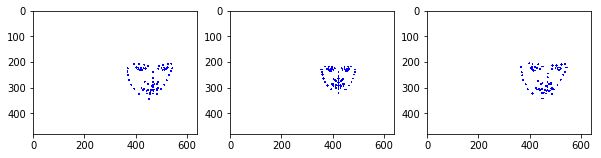

In [128]:
np.set_printoptions(suppress=True, precision=3)

RPY = np.zeros((3,1))
RPY[0,0]=0.0
RPY[1,0]=0.7
RPY[2,0]=0.0

T = np.array([[100.0/ 100.0,0.0,500.0/ 100.0]]).T
#T = np.zeros((3,1)).T

roll = RPY[0,0]
pitch = RPY[1,0]
yaw = RPY[2,0]

R = RotY(yaw).dot(RotX(pitch).dot(RotZ(roll)))

C = load_points(points_3d_s, apply_revert = True, apply_translation = False)

measurements = f(RPY, T, K, C) #shape (2L, 69L)
measurements = measurements + random_noise
RPY_est, t_est = optimise(C, measurements, K, alpha = 1.0, iterations = 20)

print "RPY GT"
print RPY
print "t GT"
print T
print "RPY_estt"
print RPY_est
print "t_est"
print t_est

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()

print "first two figures are without noise, last figure has the noise injected"

model = f_no_persp(RPY, T, C)
plotPerspective_V3(model, img_w, img_h, fig, subplot_code = 131)
plotOrthographic_V3(model, img_w, img_h, fig, subplot_code = 132)
plotComputedProjection( measurements, img_w, img_h, fig, subplot_code= 133)
plt.show()

<IPython.core.display.Javascript object>


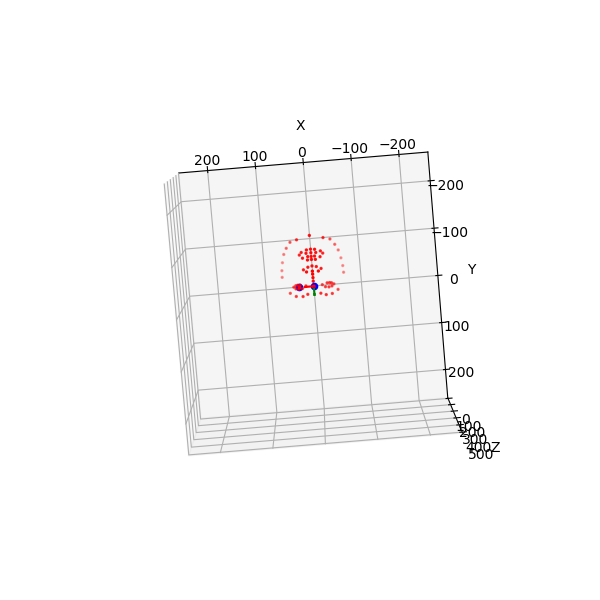

0.439285714286


In [295]:
plt.rcParams['figure.figsize'] = [6, 6]
fig = plt.figure()
R = RotX(0.7).dot(RotZ(0)).dot(RotY(0))
fixed_relative_model = load_points(points_3d_s, apply_revert = False)
plotFacesModel(fixed_relative_model, R1, C1, R2, C2, f_mm, fig, subplot_code = 111, fov_x = fov_x, fov_y = fov_y) 
plt.show()

In [340]:
check_df_dR(K,C = load_points(points_3d_s, apply_revert = True))

df_dR_numeric_all, 
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -64.   0.   0.]]
df_dr_analytic, 
[[-55.082 -28.489  15.455   0.      0.      0.    -15.339  -7.934   4.304]
 [  0.      0.      0.    -41.311 -21.367  11.591  -1.532  -0.792   0.43 ]]
difference 
[[-55.082 -28.489  15.455   0.      0.      0.    -15.339  -7.934   4.304]
 [  0.      0.      0.    -41.311 -21.367  11.591  62.468  -0.792   0.43 ]]


In [487]:
print K

[[728.455   0.      0.   ]
 [  0.    546.341   0.   ]
 [  0.      0.      1.   ]]


<IPython.core.display.Javascript object>


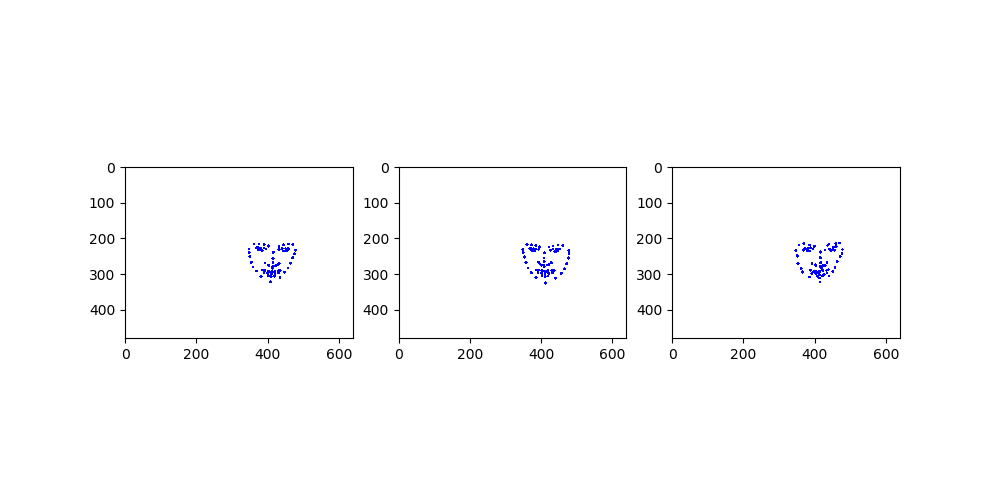

first two figures are without noise, last figure has the noise injected


In [537]:
PYR = PYR_est
T = t_est


pitch = PYR[0,0]
yaw = PYR[1,0]
roll = PYR[2,0]
R = RotX(pitch).dot(RotZ(yaw)).dot(RotY(roll))

C = load_points(points_3d_s, apply_revert = True, apply_translation = False)

measurements = f(PYR, T, K, C) #shape (2L, 69L)
measurements = measurements + np.random.randn(2,69) * 2

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()

print "first two figures are without noise, last figure has the noise injected"

model = f_no_persp(PYR, T, C)
plotPerspective_V3(model, img_w, img_h, fig, subplot_code = 131)
plotOrthographic_V3(model, img_w, img_h, fig, subplot_code = 132)
plotComputedProjection( measurements, img_w, img_h, fig, subplot_code= 133)
plt.show()

In [ ]:
Impro